In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import seaborn as sns


from access_biology_data import properties, annotation
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export

from access_science_shared import standardizer, utils

In [5]:
from scipy.stats import spearmanr



In [6]:
from scipy.stats import mannwhitneyu

In [7]:
from scipy.stats import spearmanr
from natsort import natsorted

In [8]:
save_images = False

In [9]:
outfolder = '211201_anti_aging_interventions'

In [10]:
def dump(name):
    
    if save_images:
        export.export_image(
            f'{outfolder}/{name}.pdf')




In [11]:
ref_genes = standardizer.reference_genes(10090, 'orp')

pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']
].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [12]:
sys.path.append('./../../../prepare_gustav/src')

In [13]:
# from gustav import mapper

In [14]:
ref_genes = standardizer.reference_genes(10090, 'orp')


In [15]:
from gustav import mapper

In [16]:
def get_paper(sub):
    p = inout.get_internal_path(
            'datasets/general/resources/publications/{}'.format(sub)
    )
    return p

# Myc loss

In [17]:
p = get_paper(
    'hofmann_2015/NIHMS649288-supplement-11.xlsx'
)

In [18]:
df = pd.read_excel(p).dropna(subset=['ID']).rename(columns={'ID': 'gene_ncbi'})

df = df.drop(columns=['Symbol', 'Name']).set_index('gene_ncbi').stack()
df = df.to_frame('change').rename_axis(['gene_ncbi', 'condition']).reset_index()
df['age'] = df['condition'].str.extract('^.*/(.*)$')
df['tissue'] = df['condition'].str.extract('^(.*)/.*$')
df['up'] = df['change']>0

d = pd.merge(df, pr)

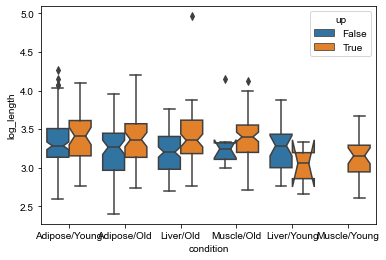

In [19]:
sns.boxplot(x='condition', hue='up', y='log_length', data=d, notch=True)

dump('myc')

In [20]:
d.groupby(['condition', 'up']).size()

condition      up   
Adipose/Old    False     67
               True      54
Adipose/Young  False    135
               True      41
Liver/Old      False    102
               True      67
Liver/Young    False     27
               True       3
Muscle/Old     False      8
               True      82
Muscle/Young   True      28
dtype: int64

In [21]:
for condition in sorted(d['condition'].unique()):
    
    e = d[d['condition']==condition]

    pval = mannwhitneyu(
        e[e['up']==True]['length'],
        e[e['up']==False]['length'],
        alternative='two-sided'
    )
    
    print(condition, pval)

Adipose/Old MannwhitneyuResult(statistic=2180.0, pvalue=0.05338283565376788)
Adipose/Young MannwhitneyuResult(statistic=3174.0, pvalue=0.1553382841537677)
Liver/Old MannwhitneyuResult(statistic=4447.0, pvalue=0.0009373349135653636)
Liver/Young MannwhitneyuResult(statistic=21.0, pvalue=0.18902390052751938)
Muscle/Old MannwhitneyuResult(statistic=413.0, pvalue=0.23089395749460095)
Muscle/Young MannwhitneyuResult(statistic=0.0, pvalue=0.0)


/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


# Snell dwarf???

Hoffmann et al. 2020 shows reports on interaction with genotype (which is significant for mild length-association). However, their supplemental table does not tell which phenotype (directionality) and labels of supplemental tables and main text appear discordant

In [22]:
p = get_paper(
    'hoffman_2020/aging-12-102822-s009..xlsx'
)

In [23]:
df = pd.read_excel(p, skiprows=1).rename(columns={'Transcript': 'symbol', 'Genotype Estimate': 'fold_change'})

df = df.groupby('symbol')['fold_change'].median().reset_index()

df = mapper.symbol_2_gene_ncbi(df, 10090)



In [24]:
df = pd.read_excel(p, skiprows=1)



In [25]:
# df = df[df['Genotype p-value']<0.05]

In [26]:
df = df.rename(columns={'Transcript': 'symbol', 'Genotype Estimate': 'fold_change'})

In [27]:
df = df.groupby('symbol')['fold_change'].median().reset_index()

df = mapper.symbol_2_gene_ncbi(df, 10090)




In [28]:
d = pd.merge(df, pr)

d['up'] = d['fold_change'] > 0

In [29]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )
    

MannwhitneyuResult(statistic=11867326.5, pvalue=0.0002447513545243694)

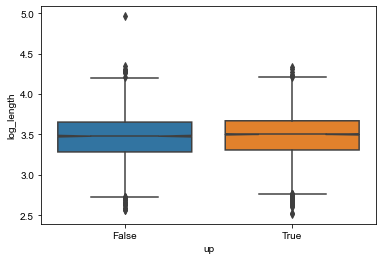

In [30]:
sns.boxplot(x='up', y='log_length', data=d, notch=True)

dump('snell')

In [31]:
d['up'].value_counts()

True     6002
False    3788
Name: up, dtype: int64

# Every other day

In [32]:
p = get_paper(
    'ng_2019/13._Ng_et_al.,_2019-Table_S8_Top_50_Common_Genes_Liver_List.xlsx'
)

In [33]:
df = pd.read_excel(p).rename(columns={'#Gene name': 'symbol', 'EOD log2FoldChange': 'fold_change'})

In [34]:
df = mapper.symbol_2_gene_ncbi(
    df[['symbol', 'fold_change']].groupby('symbol').median(),
    10090
).reset_index()

In [35]:
d = pd.merge(df, pr)



In [36]:
d['up'] = d['fold_change'] > 0

In [37]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )

MannwhitneyuResult(statistic=124.5, pvalue=0.69190283161027)

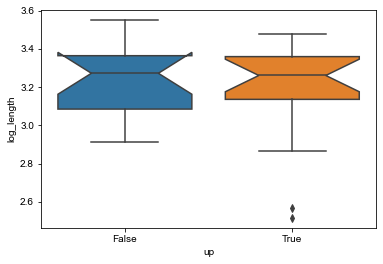

In [38]:
sns.boxplot(x='up', y='log_length', data=d, notch=True)

dump('every_other_day')

In [39]:
d['up'].value_counts()

True     17
False    16
Name: up, dtype: int64

# Little and dwarf mice

## Ames dwarf

In [40]:
p = get_paper(
    'amador_noguez_2004/acel_125_sm_tables1.xlsx'
)

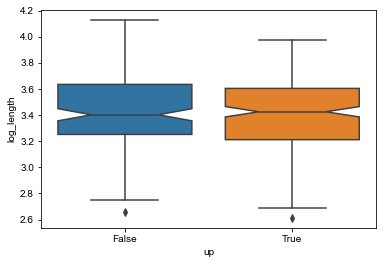

In [41]:
df = pd.read_excel(p, skiprows=7)
d = mapper.symbol_2_gene_ncbi(df.rename(columns={'Gene': 'symbol'}).set_index('symbol'), 10090).reset_index()

d = pd.merge(d.groupby(['gene_ncbi'])['Fold Change'].median().reset_index(), pr)


d['up'] = d['Fold Change'] > 1

sns.boxplot(x='up', y='log_length', data=d, notch=True)

dump('ames')

In [42]:
d['up'].value_counts()

True     240
False    167
Name: up, dtype: int64

In [43]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )



MannwhitneyuResult(statistic=19182.5, pvalue=0.46286456040764623)

## Little

In [44]:
p = get_paper(
    'amador_noguez_2004/acel_125_sm_tables2.xlsx'
)

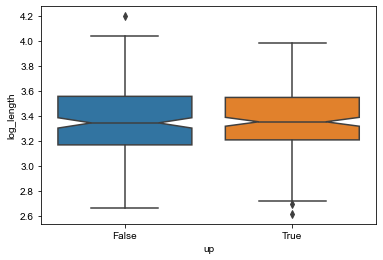

In [45]:
df = pd.read_excel(p, skiprows=7)

d = mapper.symbol_2_gene_ncbi(df.rename(columns={'Common': 'symbol'}).set_index('symbol'), 10090).reset_index()
d = pd.merge(d.groupby(['gene_ncbi'])['Fold Change'].median().reset_index(), pr)



d = pd.merge(d, pr)



d['up'] = d['Fold Change'] > 1

sns.boxplot(x='up', y='log_length', data=d, notch=True)

dump('little')

In [46]:
d['up'].value_counts()

True     225
False    216
Name: up, dtype: int64

In [47]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )

MannwhitneyuResult(statistic=25090.0, pvalue=0.5551344333465682)

In [48]:
d.shape

(441, 5)

# S6k

In [49]:
p = get_paper(
    'selman_2009/extracted_supplemental_tables.xlsx'
)

In [50]:
agg = []
for sheet in ['s2a', 's2b', 's3a', 's3b', 's4a', 's4b']:

    df = pd.read_excel(p, sheet_name=sheet)
    df.loc[:, 'sheet'] = sheet
    agg.append(df)

In [51]:
df = pd.concat(agg)
df['perturbation'] = df['sheet'].apply(lambda x: x[:2])

In [52]:
f = df['sheet'].apply(lambda x: x[-1]) == 'b'

In [53]:
df.loc[f, 'fc'] = -df.loc[f, 'fc']

In [54]:
d = df.groupby(['symbol', 'perturbation'])['fc'].median().reset_index()

In [55]:

d = mapper.symbol_2_gene_ncbi(d.set_index('symbol'), 10090).reset_index()

d = pd.merge(d, pr)



In [56]:
d['up'] = d['fc']>0

In [57]:
d['perturbation'] = d['perturbation'].replace({'s2': 'liver', 's3': 'muscle', 's4': 'adipose tissue'})

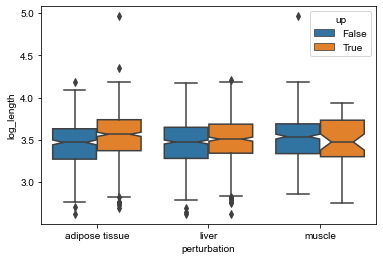

In [58]:
sns.boxplot(
    x='perturbation',
    y='log_length',
    hue='up',
    data=d,
    notch=True,
    order=sorted(['liver', 'muscle', 'adipose tissue'])
)

dump('s6k')

In [59]:
d.groupby(['perturbation', 'up']).size()

perturbation    up   
adipose tissue  False    392
                True     520
liver           False    600
                True     494
muscle          False    374
                True      50
dtype: int64

In [60]:
for condition in sorted(d['perturbation'].unique()):
    
    e = d[d['perturbation']==condition]

    pval = mannwhitneyu(
        e[e['up']==True]['length'],
        e[e['up']==False]['length'],
        alternative='two-sided'
    )
    
    print(condition, pval)

adipose tissue MannwhitneyuResult(statistic=121887.5, pvalue=3.9743875535286104e-07)
liver MannwhitneyuResult(statistic=162165.0, pvalue=0.007249541048162262)
muscle MannwhitneyuResult(statistic=8820.5, pvalue=0.5156749070659525)


# HUMAN

In [61]:
ref_genes = standardizer.reference_genes(9606, 'orp')

pr = properties.genbank_validated_rna(9606)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']
].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

# FGF21 increase

In [62]:
p = get_paper(
    'murray_2020/Supp Tables Full resubmit.xlsx'
)

In [63]:
df = pd.read_excel(p, 'S1a AT DEG')     # adipose tissue

df = mapper.gene_ensembl_2_gene_ncbi(
    df[['GeneID', 'Post.vs.Pre_logFC']].rename(columns={
        'GeneID': 'gene_ensembl',
        'Post.vs.Pre_logFC': 'fold_change'
    }),
    9606
).reset_index()

d = pd.merge(df, pr)

In [64]:
d['up'] = d['fold_change'] > 0

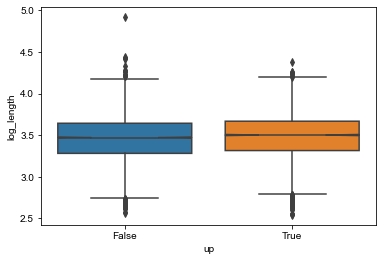

In [65]:
sns.boxplot(
    x='up',
    y='log_length',
    data=d,
    notch=True
)

dump('fgf21_adipose_tissue')

In [66]:
spearmanr(d['length'], d['fold_change'])

SpearmanrResult(correlation=0.029058820885486867, pvalue=0.0010731387874629958)

In [67]:
d['up'].value_counts()

True     6700
False    5965
Name: up, dtype: int64

In [68]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )

MannwhitneyuResult(statistic=21190187.5, pvalue=4.130606733104396e-09)

In [69]:
df = pd.read_excel(p, 'S1b SM DEG')    # Skeletal muscle

df = mapper.gene_ensembl_2_gene_ncbi(
    df[['GeneID', 'Post.vs.Pre_logFC']].rename(columns={
        'GeneID': 'gene_ensembl',
        'Post.vs.Pre_logFC': 'fold_change'
    }),
    9606
).reset_index()

d = pd.merge(df, pr)

In [70]:
spearmanr(d['length'], d['fold_change'])

SpearmanrResult(correlation=0.14985628603386897, pvalue=1.710688759433346e-59)

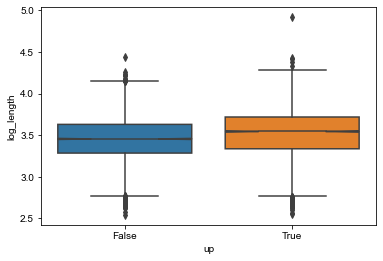

In [71]:
d['up'] = d['fold_change'] > 0

sns.boxplot(
    x='up',
    y='log_length',
    data=d,
    notch=True
)

dump('fgf21_skeletal_muscle')

In [72]:
d['up'].value_counts()

False    6731
True     4921
Name: up, dtype: int64

In [73]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )

MannwhitneyuResult(statistic=19195709.5, pvalue=7.802523234295987e-49)

# Metformin


In [74]:
p = get_paper(
    'luizon_2015/pgen.1006449.s008.xlsx'
)

In [75]:
df = pd.read_excel(p, skiprows=1).rename(columns={'GeneID': 'gene_ensembl', 'log2FoldChange': 'fold_change'})

In [76]:
df = df.dropna(subset=['padj'])

In [77]:
df = mapper.gene_ensembl_2_gene_ncbi(
    df[['gene_ensembl', 'fold_change']], 
    9606)

In [78]:
d = pd.merge(df, pr)

In [79]:
spearmanr(d['length'], d['fold_change'])

SpearmanrResult(correlation=0.025555656922209517, pvalue=0.007053878242231925)

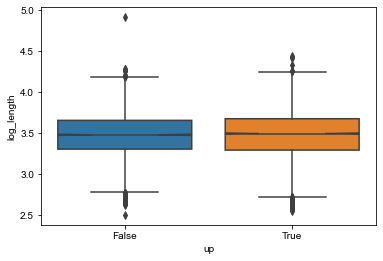

In [80]:
d['up'] = d['fold_change'] > 0

sns.boxplot(
    x='up',
    y='log_length',
    data=d,
    notch=True
)

dump('metformin')

In [81]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )

MannwhitneyuResult(statistic=15590942.0, pvalue=0.2322538176883423)

In [82]:
d['up'].value_counts()

True     5876
False    5238
Name: up, dtype: int64

# Resveratrol



In [83]:
p = get_paper(
    'dembic_2019/ScienceDirect_files_16Nov2021_22-07-17.076/1-s2.0-S1096719218304955-mmc3.xlsx'
)



df = pd.read_excel(p).rename(columns={'Ensembl_ID': 'gene_ensembl', 'log2FoldChange': 'fold_change'})

df = df.dropna(subset=['padj'])


df =  mapper.gene_ensembl_2_gene_ncbi(df[['gene_ensembl', 'fold_change']], 9606)

d = pd.merge(df, pr)

In [84]:
spearmanr(d['length'], d['fold_change'])

SpearmanrResult(correlation=0.034169885222255496, pvalue=0.00022113533346859428)

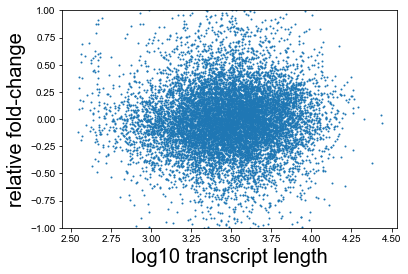

In [85]:
plt.scatter(d['log_length'], d['fold_change'], s=1)
plt.ylim([-1, 1])
plt.xlabel('log10 transcript length', fontsize=20)
plt.ylabel('relative fold-change', fontsize=20)


dump('resveratrol_scatter')

In [86]:
d['up'] = d['fold_change'] > 0

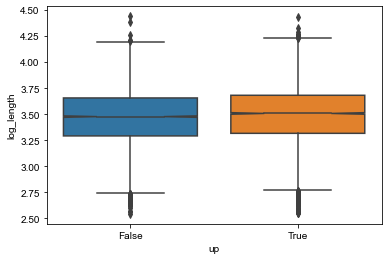

In [87]:
sns.boxplot(
    x='up',
    y='log_length',
    data=d,
    notch=True
)


dump('resveratrol')

In [88]:
mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )



MannwhitneyuResult(statistic=17909629.0, pvalue=1.0460825293670806e-06)

In [89]:
d['up'].value_counts()

False    6093
True     5587
Name: up, dtype: int64

# senolytics


In [90]:
p = get_paper(
    'jochems_2021/mmc2.xlsx'
)


df = pd.read_excel(p).dropna(subset=['Padj'])

df = df[['Gene name', 'LogFC']].rename(columns={
    'Gene name': 'symbol',
    'LogFC': 'fold_change'
}).groupby('symbol').median().reset_index()



In [91]:
df['symbol'] = df['symbol'].astype(str)

In [92]:
from gustav import ncbi

In [93]:
df = mapper.symbol_2_gene_ncbi(df, 9606)

In [94]:
df

,gene_ncbi,fold_change
0,1,-0.222755
1,2,0.612446
2,9,0.610973
3,10,2.438792
4,12,0.793623
...,...,...
17557,114108587,0.606954
17558,114515521,0.852736
17559,115072896,-0.216661
17560,115804232,0.492588


In [95]:
d = pd.merge(df, pr)

In [96]:
spearmanr(d['length'], d['fold_change'])

SpearmanrResult(correlation=0.04668982063385679, pvalue=6.985043826051486e-09)

In [97]:
d['up'] = d['fold_change'] > 0



MannwhitneyuResult(statistic=31058655.5, pvalue=1.0086981164760444e-12)

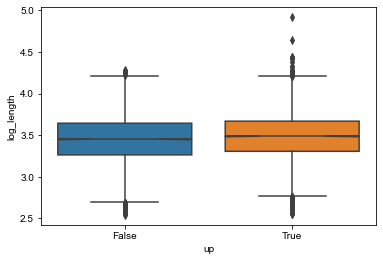

In [98]:
sns.boxplot(
    x='up',
    y='log_length',
    data=d,
    notch=True
)

dump('senolytics')


mannwhitneyu(
        d[d['up']==True]['length'],
        d[d['up']==False]['length'],
        alternative='two-sided'
    )

In [99]:
d['up'].value_counts()

True     8604
False    6767
Name: up, dtype: int64